## 1. Data Exploration

In [1]:
# loading libraries and mnist data

import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
import keras
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn import svm
from sklearn import neighbors as knn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

### 1.1 Dimensionality

**What is the type of the training and testing datasets?**

The data is in the form of 28x28 pixel images stored as numpy arrays, where each pixel is represented by a number between 0 and 255.
0 is black and 255 is white. The images are digits from 0 to 9.

**How many features are in the training dataset? The testing dataset? How many samples are in each dataset?**

Training data contains 60,000 images and test data includes 10,000. Each image corresponds to 28x28 resolution i.e. 784 pixels/features.

**If an array has a shape of (100, 28, 28), what does each number represent in the context of image data (i.e., which number represents the number of images, and which represent the number of pixels?), and how would it change if you flattened it to a 2D array?**

The number 100 corresponds to the total images, while 28×28 represents the resolution of each image, translating to 784 pixels. One way to flatten it into a 2D array would change the dimensionality to (100, 784), where each "image" is now represented as a row of 784 features.

**How would you convert a 3D array into a 2D array without changing the total number of elements? Describe how flatten() and reshape() can be used for this purpose.**

Let a 3D array tmp have the shape (100, 28, 28). Using flatten(), we would apply the following code: flattened_data = np.array([arr.flatten() for arr in tmp]). Using reshape(), we can simply write: flattened_data = tmp.reshape(100, -1), with both outputs having a shape of (100, 784).

In [2]:
tmp = np.random.randint(0,255,size = (100, 28, 28))
flattened_data = np.array([arr.flatten() for arr in tmp])
print(flattened_data.shape)
flattened_data = tmp.reshape(100, -1)
print(flattened_data.shape)

(100, 784)
(100, 784)


**Explain why it’s necessary to reshape data when transitioning from raw images to model input, particularly in neural networks. What are the implications of reshaping an image array into a vector (1D array) for each sample? (Feel free to turn to Google for this, as long as you cite your sources**

Reshaping data is necessary because some neural network layers, such as convolutional layers, only accept inputs with specific dimensionalities. This is because they have been trained on a particular image size and/or require it for training. For example, the VGG-16 architecture requires an input image size of 224×224×3. Flattening an image into a 1D array is more computationally efficient as it uses less memory; however, it results in the loss of important spatial information.

### 1.2 Visualization

**Select one random example from each category in the testing set, display each 2D image, and label it with the corresponding category name.**

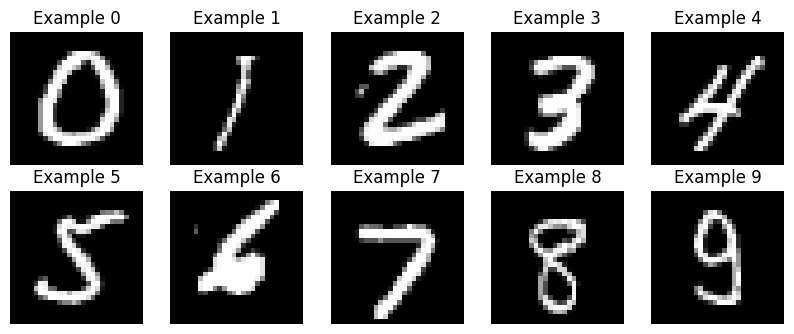

In [3]:
unique_categories = np.unique(y_test)

example = []
for category in unique_categories:
    indices = np.where(y_test == category)[0]
    random_choice = random.choice(indices)
    example.append(x_test[random_choice])

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5,5,i + 1)
    plt.imshow(example[i], cmap='gray')
    plt.title(f'Example {i}')
    plt.axis('off')
plt.show()

## 2. Data Processing

### 2.1 Subsetting

**Create a 10% random subset of each training and testing set. What is the distribution of each label in the initial train data? What is the distribution of each label in the reduced train data?**

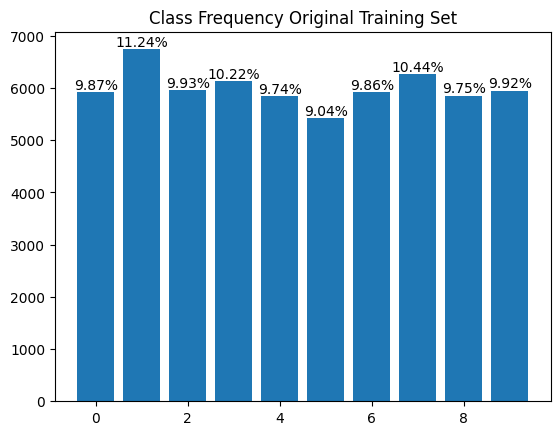

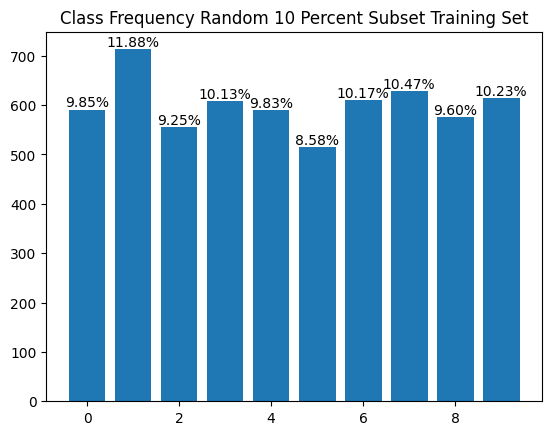

In [4]:
x_train_subset_rand, _, y_train_subset_rand, _ = train_test_split(x_train, y_train, test_size=0.9, random_state=10)
x_test_subset_rand, _, y_test_subset_rand, _ = train_test_split(x_test, y_test, test_size=0.9, random_state=10)

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Frequency Original Training Set')
for i, count in enumerate(counts):
    plt.text(unique[i], count, f'{count/len(y_train)*100:.2f}%', ha='center', va='bottom')
plt.show()

unique, counts = np.unique(y_train_subset_rand, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Frequency Random 10 Percent Subset Training Set')
for i, count in enumerate(counts):
    plt.text(unique[i], count, f'{count/len(y_train_subset_rand)*100:.2f}%', ha='center', va='bottom')
plt.show()

**Now subset the first 10% of each training and testing set. What is the distribution of each label in the initial train data? What is the distribution of each label in the reduced train data?**

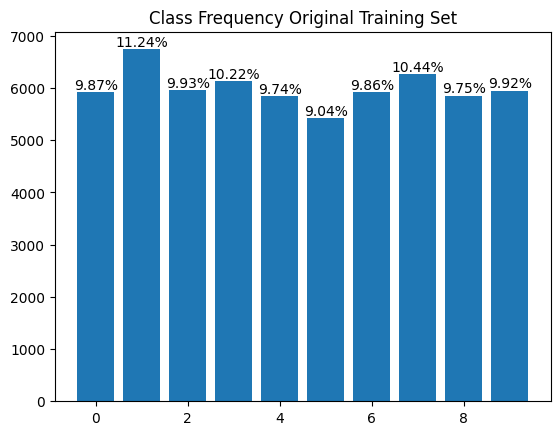

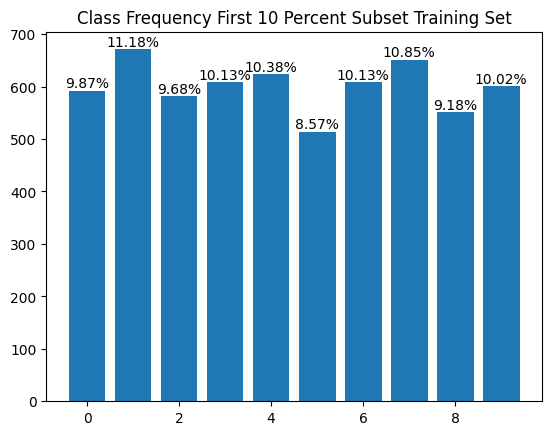

In [5]:
subset_value_train = int (0.1 * len(x_train))
subset_value_test = int (0.1 * len(x_test))
x_train_subset_first_10, y_train_subset_first_10 = x_train[:subset_value_train], y_train[:subset_value_train]
x_test_subset_first_10, y_test_subset_first_10 = x_test[:subset_value_test], y_test[:subset_value_test]

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Frequency Original Training Set')
for i, count in enumerate(counts):
    plt.text(unique[i], count, f'{count/len(y_train)*100:.2f}%', ha='center', va='bottom')
plt.show()

unique, counts = np.unique(y_train_subset_first_10, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Frequency First 10 Percent Subset Training Set')
for i, count in enumerate(counts):
    plt.text(unique[i], count, f'{count/len(y_train_subset_first_10)*100:.2f}%', ha='center', va='bottom')
plt.show()

**When reducing dataset size, what differences might you expect to see in results between randomly selecting samples versus selecting the first portion of the dataset? Is this borne out by the subsets you just created? How does the distribution of the labels in the various subsampled datasets compare to the distribution of the full datasets?**

A random sample is less likely to be biased compared to selecting the first portion of the data. For example, the original training data could be ordered numerically in ascending order. Choosing the first portion would replicate this bias, whereas a random sample would not have this issue. This can also be observed in the distributions above. Although not as pronounced, the first 10% portion still exhibits clear biases compared to a randomly selected subset.

Original vs. Random Sample Comparison: Both distributions are surprisingly similar since the subset was randomly selected from the original training set. Therefore, the subset serves as a good representation, although the number of samples is, of course, much smaller, as only 10% of the data was selected. However, some issues remain—for example, 5 appears to be underrepresented, while 1 is overrepresented.

Original vs. First Portion Comparison: Substantial differences can be observed between the class frequencies of the original training set and the first 10% subset. For example, 2, 3, and 4 have roughly equal frequencies in the original training set, but in the first 10% subset, these labels have an upward trend. Additionally, 5 and 8 are underrepresented in the first 10% subset compared to the original training set.

**Why might subsampling a dataset be beneficial when developing machine learning models? Discuss the trade-offs.**

Subsampling can be beneficial in speeding up the training process; however, as seen in the examples above, it may introduce potential biases, especially if the subsample is not random. Even if the subsample is random, less frequent classes may still not be included in a small sample.


### 2.2 Feature Engineering

**What are the features versus the output in this assignment? Why is it important to distinguish between features (inputs) and outputs (labels) in a machine learning model?**

The inputs (features) consist of the 784 pixel values of each image, while the corresponding digit label (0–9) serves as the output. Since, at a high level of abstraction, any ML/DL algorithm is a function that maps an input to an output, it is crucial to distinguish between the two; otherwise, training would not be possible.

**Select all train images labeled "3". Create a single, pixel-wise average image of all of these images. Plot the 2D mean and standard deviation images for category 3 in both the training and testing sets. Comment on the differences between the mean and standard deviation images between the training and testing datasets. Plot the 2D mean and standard deviation images for category "3" in the training and testing sets for the binarized images.**

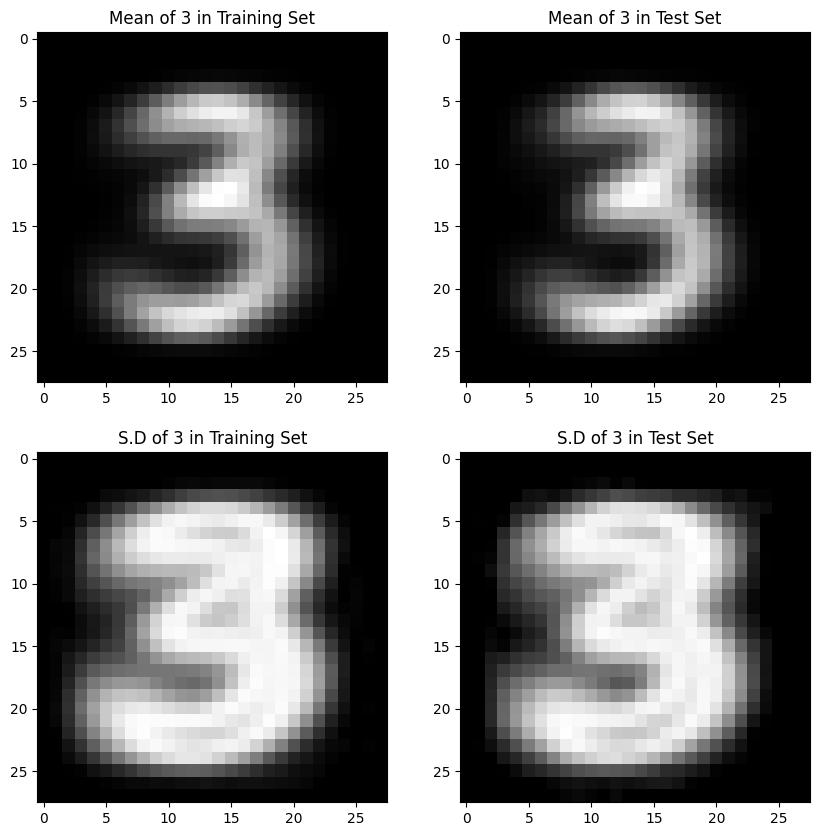

In [6]:
indices_train_3 = np.where(y_train == 3)[0]
x_train_subset_3 = x_train[indices_train_3]

indices_test_3 = np.where(y_test == 3)[0]
x_test_subset_3 = x_test[indices_test_3]

mean_train_3 = x_train_subset_3.mean(axis=0)
mean_test_3 = x_test_subset_3.mean(axis=0)

sd_train_3 = x_train_subset_3.std(axis=0)
sd_test_3 = x_test_subset_3.std(axis=0)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(mean_train_3, cmap='gray')
plt.title('Mean of 3 in Training Set')

plt.subplot(2, 2, 2)
plt.imshow(mean_test_3, cmap='gray')
plt.title('Mean of 3 in Test Set')


plt.subplot(2, 2, 3)
plt.imshow(sd_train_3, cmap='gray')
plt.title('S.D of 3 in Training Set')

plt.subplot(2, 2, 4)
plt.imshow(sd_test_3, cmap='gray')
plt.title('S.D of 3 in Test Set')
plt.show()

Both mean images are very similar, with hardly any noticeable difference between them, implying that both datasets have similar appearance. However, for SD images, the testing image appears visibly brighter, particularly in the top, middle, and bottom regions, indicating that the testing images have higher variability in those areas compared to the training images.

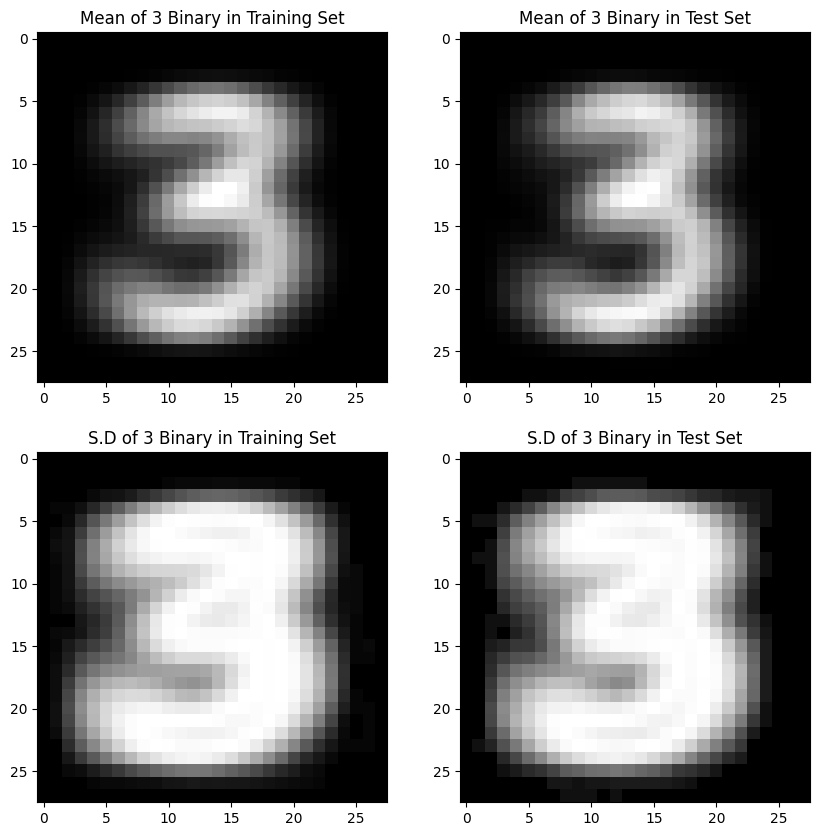

In [7]:
x_train_subset_3_binary = np.where(x_train_subset_3 > mean_train_3, 1, 0)
x_test_subset_3_binary = np.where(x_test_subset_3 > mean_test_3, 1, 0)

mean_train_3_binary = x_train_subset_3_binary.mean(axis=0)
mean_test_3_binary = x_test_subset_3_binary.mean(axis=0)

sd_train_3_binary = x_train_subset_3_binary.std(axis=0)
sd_test_3_binary = x_test_subset_3_binary.std(axis=0)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(mean_train_3_binary, cmap='gray')
plt.title('Mean of 3 Binary in Training Set')

plt.subplot(2, 2, 2)
plt.imshow(mean_test_3_binary, cmap='gray')
plt.title('Mean of 3 Binary in Test Set')


plt.subplot(2, 2, 3)
plt.imshow(sd_train_3_binary, cmap='gray')
plt.title('S.D of 3 Binary in Training Set')

plt.subplot(2, 2, 4)
plt.imshow(sd_test_3_binary, cmap='gray')
plt.title('S.D of 3 Binary in Test Set')
plt.show()

**Now repeat this for a new label (e.g., "7"). Comment on the differences between the mean and standard deviation images between the training and testing datasets for the binarized images.**

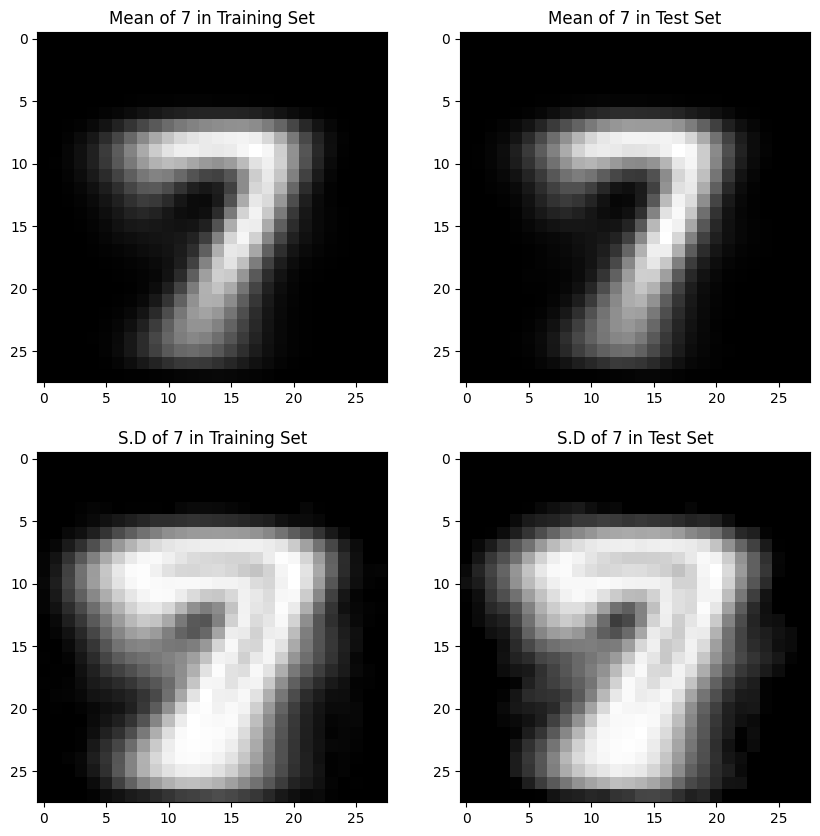

In [8]:
indices_train_7 = np.where(y_train == 7)[0]
x_train_subset_7 = x_train[indices_train_7]

indices_test_7 = np.where(y_test == 7)[0]
x_test_subset_7 = x_test[indices_test_7]

mean_train_7 = x_train_subset_7.mean(axis=0)
mean_test_7 = x_test_subset_7.mean(axis=0)

sd_train_7 = x_train_subset_7.std(axis=0)
sd_test_7 = x_test_subset_7.std(axis=0)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(mean_train_7, cmap='gray')
plt.title('Mean of 7 in Training Set')

plt.subplot(2, 2, 2)
plt.imshow(mean_test_7, cmap='gray')
plt.title('Mean of 7 in Test Set')


plt.subplot(2, 2, 3)
plt.imshow(sd_train_7, cmap='gray')
plt.title('S.D of 7 in Training Set')

plt.subplot(2, 2, 4)
plt.imshow(sd_test_7, cmap='gray')
plt.title('S.D of 7 in Test Set')
plt.show()

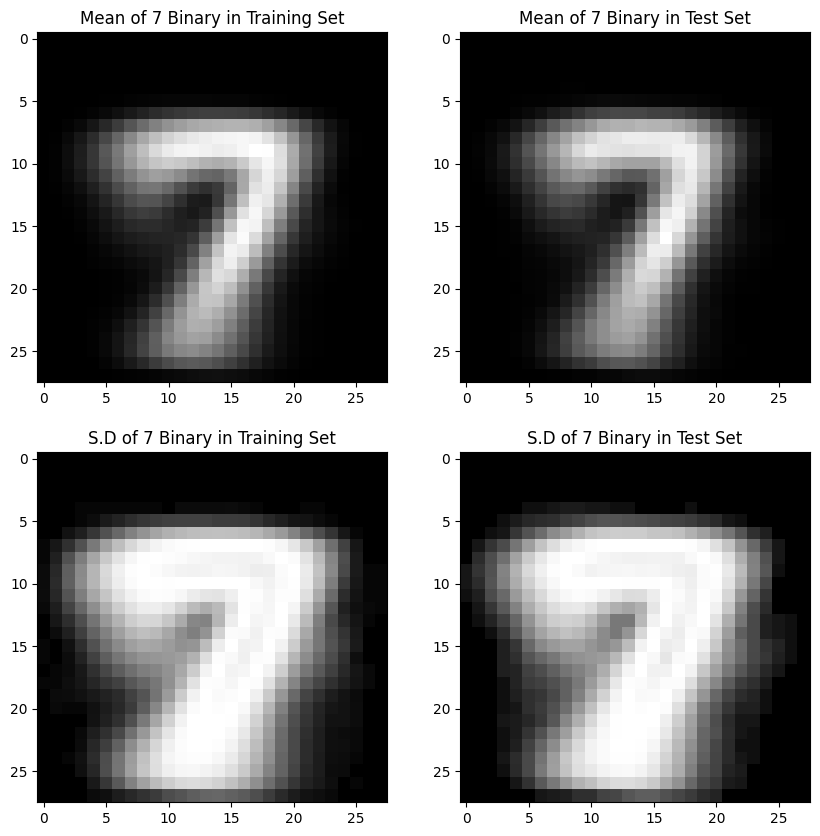

In [9]:
x_train_subset_7_binary = np.where(x_train_subset_7 > mean_train_7, 1, 0)
x_test_subset_7_binary = np.where(x_test_subset_7 > mean_test_7, 1, 0)

mean_train_7_binary = x_train_subset_7_binary.mean(axis=0)
mean_test_7_binary = x_test_subset_7_binary.mean(axis=0)

sd_train_7_binary = x_train_subset_7_binary.std(axis=0)
sd_test_7_binary = x_test_subset_7_binary.std(axis=0)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(mean_train_7_binary, cmap='gray')
plt.title('Mean of 7 Binary in Training Set')

plt.subplot(2, 2, 2)
plt.imshow(mean_test_7_binary, cmap='gray')
plt.title('Mean of 7 Binary in Test Set')


plt.subplot(2, 2, 3)
plt.imshow(sd_train_7_binary, cmap='gray')
plt.title('S.D of 7 Binary in Training Set')

plt.subplot(2, 2, 4)
plt.imshow(sd_test_7_binary, cmap='gray')
plt.title('S.D of 7 Binary in Test Set')
plt.show()

As with the Category 3 images, the mean images of the binarized train and test data appear to be very similar, with hardly any noticeable differences. The test image can be said to have higher standard deviation (SD) values, indicating greater variability, particularly in the middle section. However, this difference is also not substantial.

**Binarize both of the images from the previous question by setting pixel values equal to 1 if they are greater than the mean value for that pixel and equal to 0 if they are less than the mean value for that pixel.**

*Answered in previous part, assuming this question was out of order.*

**In plain English, what are we actually doing when we binarize an image? How does the new pixel value relate to the pixel value of the original image and the mean value for that pixel across all images with that label?** 

The images in our case represent grayscale values ranging from 0 to 255, where 0 corresponds to pure black and 255 corresponds to pure white. By binarizing an image, we treat pixel values above a threshold (in our case, the mean of each pixel) as equally important and assign them a value of 1. Conversely, pixel values below the mean are considered equally less important and are assigned a value of 0. This process results in a high-contrast image composed solely of pure black and pure white.

**What is the index of the most dissimilar image in category "3" in the training set for the regular images? What about the most similar image? Does this change for the binarized images? If so, why? Make sure to plot all four images with approproate labels.**

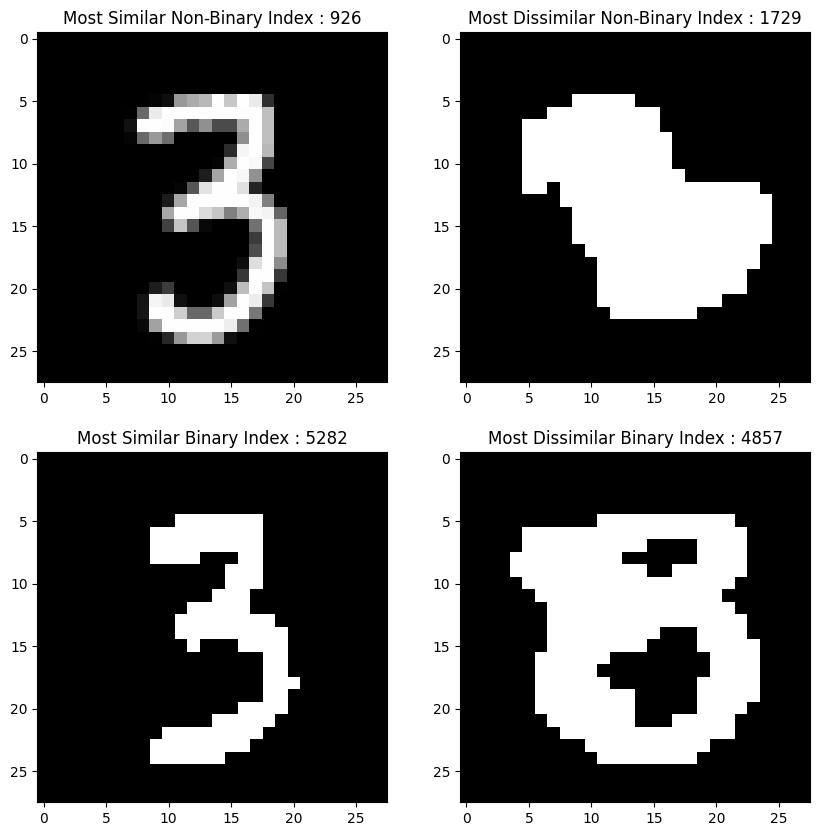

In [10]:
distances_using_mean_non_binary = [euclidean(mean_train_3.flatten(), img.flatten()) for img in x_train_subset_3]
most_similar_index_non_binary = np.argmin(distances_using_mean_non_binary)
most_dissimilar_index_non_binary = np.argmax(distances_using_mean_non_binary)

distances_using_mean_binary = [euclidean(mean_train_3_binary.flatten(), img.flatten()) for img in x_train_subset_3_binary]
most_similar_index_binary = np.argmin(distances_using_mean_binary)
most_dissimilar_index_binary = np.argmax(distances_using_mean_binary)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(x_train_subset_3[most_similar_index_non_binary], cmap='gray')
plt.title('Most Similar Non-Binary Index : ' + str(most_similar_index_non_binary))

plt.subplot(2, 2, 2)
plt.imshow(x_train_subset_3[most_dissimilar_index_non_binary], cmap='gray')
plt.title('Most Dissimilar Non-Binary Index : ' + str(most_dissimilar_index_non_binary))

plt.subplot(2, 2, 3)
plt.imshow(x_train_subset_3_binary[most_similar_index_binary], cmap='gray')
plt.title('Most Similar Binary Index : ' + str(most_similar_index_binary))

plt.subplot(2, 2, 4)
plt.imshow(x_train_subset_3_binary[most_dissimilar_index_binary], cmap='gray')
plt.title('Most Dissimilar Binary Index : ' + str(most_dissimilar_index_binary))

plt.show()

Both indices change because the binarized image consists of values between 0 and 1, whereas the non-binary image contains values ranging from 0 to 255. As a result, each set has different mean pixel values and hence different distance values for each index.

**What do you think the effect of binarizing these images is from a machine learning perspective? How does binarization of images (converting pixel values to 0 or 1 based on a threshold) affect the representation of features, and what might be the benefits and limitations of this approach?**

Binarization leads to more computationally efficient and simplified calculations, resulting in reduced training duration. However, as mentioned earlier, when we assign equal importance or insignificance to pixel values based on a threshold, we lose specific details in the image that could be beneficial for training.

**How does what you've just done relate to the idea of standardizing data? Why might it be important to standardize our data before using it to train a model?**

Data standardization involves converting feature values on different scales to a standard scale with a mean of zero and a standard deviation of 1. This technique improves model training speed and ensures that features with larger values do not disproportionately influence the results. Although binarization also involves converting values on different scales to 0 and 1, the use of thresholding and binarization result in the loss of important information. Therefore, binarization is distinct from data standardization.

**Describe how calculating a pixel-wise mean or standard deviation for a set of images can help you understand variations within a category. What does a high standard deviation indicate in this context?**

The means help convey the importance of pixels within categories, with a higher mean corresponding to a more important pixel. The deviations help in understanding the variation in pixel values, where a higher deviation indicates a diverse set of values and, consequently, a diverse set of images.

## 3. Model Training, Validation, and Intepretation

### 3.1 Support Vector Machine

**From the training dataset, select only images from categories "3" and "9".Subdivide the data into Set1 and Set2, with 60% of the data in Set1 and 40% in Set2. Replace category labels with 0 for 3 and 1 for 9. Use Set1 to train a linear support vector machine classifier with default parameters and predict the class labels for Set2. What is the prediction accuracy using the model trained on the training set? What is the prediction accuracy using the model trained on the testing set?**

In [11]:
indices_train_3_9 = np.where((y_train == 3) | (y_train == 9))[0]
x_train_subset_3_9 = x_train[indices_train_3_9]
y_train_subset_3_9 = y_train[indices_train_3_9]

y_train_subset_3_9 = np.where(y_train_subset_3_9 == 3, 0, 1)

set1_X, set2_X, set1_y, set2_y = train_test_split(x_train_subset_3_9, y_train_subset_3_9, test_size=0.4, random_state=10)

set1_X_flat = set1_X.reshape(set1_X.shape[0], -1)
set2_X_flat = set2_X.reshape(set2_X.shape[0], -1)

svm_model = svm.SVC(kernel='linear')
svm_model.fit(set1_X_flat, set1_y)

set1_y_pred = svm_model.predict(set1_X_flat)
set2_y_pred = svm_model.predict(set2_X_flat)

print('Prediction Accuracy Train Set:', (set1_y == set1_y_pred).sum() / len(set1_y))
print('Prediction Accuracy Test Set:', (set2_y == set2_y_pred).sum() / len(set2_y))

Prediction Accuracy Train Set: 1.0
Prediction Accuracy Test Set: 0.9768211920529801


### 3.2 Modeling with Engineered Data

**We describe each image by using a reduced set of features (compared to n = 784 initial features for each pixel value) as follows:**

* **Binarize the image by setting the pixel values to 1 if they are greater than 128 and 0 otherwise.**
* **For each image row i, find n_i, the sum of 1's in the row (28 features).**
* **For each image column j, find n_j, the sum of 1's in the column (28 features).**
* **Concatenate these features to form a feature vector of 56 features.**

**What is the prediction accuracy using an SVM model trained on the training set? What is the prediction accuracy using an SVM model trained on the testing set? How about the prediction accuracy of a KNN model trained on the training set? And on the testing set? What does this tell you about the potential impacts of feature engineering?**

In [12]:
indices_train_3_9 = np.where((y_train == 3) | (y_train == 9))[0]
x_train_subset_3_9 = x_train[indices_train_3_9]
y_train_subset_3_9 = y_train[indices_train_3_9]

y_train_subset_3_9 = np.where(y_train_subset_3_9 == 3, 0, 1)

x_train_subset_3_9_binary = np.where(x_train_subset_3_9 > 128, 1, 0)

row_sum = x_train_subset_3_9_binary.sum(axis=1)
column_sum = x_train_subset_3_9_binary.sum(axis=2)
x_train_subset_3_9_binary_56 = np.concatenate((row_sum, column_sum), axis=1)

set1_X, set2_X, set1_y, set2_y = train_test_split(x_train_subset_3_9_binary_56, y_train_subset_3_9, test_size=0.4, random_state=10)

svm_model = svm.SVC(kernel='linear')
svm_model.fit(set1_X, set1_y)

knn_model = knn.KNeighborsClassifier()
knn_model.fit(set1_X, set1_y)

set1_y_pred_svm = svm_model.predict(set1_X)
set2_y_pred_svm = svm_model.predict(set2_X)

print('Prediction Accuracy Train Set SVM:', (set1_y == set1_y_pred_svm).sum() / len(set1_y))
print('Prediction Accuracy Test Set SVM:', (set2_y == set2_y_pred_svm).sum() / len(set2_y),'\n')

set1_y_pred_knn = knn_model.predict(set1_X)
set2_y_pred_knn = knn_model.predict(set2_X)

print('Prediction Accuracy Train Set KNN:', (set1_y == set1_y_pred_knn).sum() / len(set1_y))
print('Prediction Accuracy Test Set KNN:', (set2_y == set2_y_pred_knn).sum() / len(set2_y))

Prediction Accuracy Train Set SVM: 0.9678532008830022
Prediction Accuracy Test Set SVM: 0.9650248344370861 

Prediction Accuracy Train Set KNN: 0.9768211920529801
Prediction Accuracy Test Set KNN: 0.9720612582781457


The SVM model with feature engineering performed nearly as well as the model using all the features, with only a small reduction in accuracy for the Set 2 test set, demonstrating that, in the case of the MNIST dataset, our feature engineering techniques did not result in the loss of important details in the images while simultaneously improving computational efficiency.

### 3.3 K-Nearest Neighbors

**In the training and testing datasets, select images in the categories 1, 3, 5, 7, and 9. Train a k-NN classifier using 4 to 40 nearest neighbors, with a step size of 4.**

In [13]:
indices_train_rel = np.where((y_train == 1) | (y_train == 3) | (y_train == 5) | (y_train == 7) | 
                             (y_train == 9))[0]
x_train_subset_rel = x_train[indices_train_rel]
y_train_subset_rel = y_train[indices_train_rel]

indices_test_rel = np.where((y_test == 1) | (y_test == 3) | (y_test == 5) | (y_test == 7) | 
                            (y_test == 9))[0]
x_test_subset_rel = x_test[indices_test_rel]
y_test_subset_rel = y_test[indices_test_rel]

all_model_predictions = []

for i in range(4, 41, 4):
    knn_model = knn.KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(x_train_subset_rel.reshape(x_train_subset_rel.shape[0], -1), y_train_subset_rel)
    predictions = knn_model.predict(x_test_subset_rel.reshape(x_test_subset_rel.shape[0], -1))
    all_model_predictions.append(predictions)

**For k = 4, what is the label that was predicted with lowest accuracy?**

**For k = 20, what is the label that was predicted with lowest accuracy?**

In [14]:
j = 4
dict_class_prediction = {}
for prediction in all_model_predictions:
    tmp_dict = {}
    for i in np.unique(y_test_subset_rel):
        indices_i = np.where(y_test_subset_rel == i)
        prediction_accuracy_i = y_test_subset_rel[indices_i] == prediction[indices_i]
        tmp_dict[i] = prediction_accuracy_i.sum() / len(prediction_accuracy_i)
    dict_class_prediction[j] = tmp_dict
    j= j + 4

print('Label with minimum accuracy when k = 4:',min(dict_class_prediction[4], key=dict_class_prediction[4].get))
print('Label with minimum accuracy when k = 20:', min(dict_class_prediction[20], key=dict_class_prediction[20].get))

Label with minimum accuracy when k = 4: 9
Label with minimum accuracy when k = 20: 7


**What is the label pair that was confused most often (i.e., class A is labeled as B, and vice versa)?**

In [15]:
index_to_label = {0: 1, 1: 3, 2: 5, 3: 7, 4: 9}
mislabled_values = {}
k = 4
for prediction in all_model_predictions:
    conf_matrix = confusion_matrix(y_test_subset_rel, prediction)

    non_diag_values = {}
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            if i != j:
                index_to_label_value_i = index_to_label[i]
                index_to_label_value_j = index_to_label[j]

                if (index_to_label_value_j, index_to_label_value_i) in non_diag_values.keys():
                    non_diag_values[(index_to_label_value_j, index_to_label_value_i)] += conf_matrix[i, j]
                else:
                    non_diag_values[(index_to_label_value_i, index_to_label_value_j)] = conf_matrix[i, j]
    
    mislabled_values[k] = non_diag_values
    k += 4

for value in mislabled_values.keys():
    print(f'Label pair most confused when k = {value}:', 
    max(mislabled_values[value], key=mislabled_values[value].get),'with',max(mislabled_values[value].values()), 
    'mislabelled')
    k += 4

Label pair most confused when k = 4: (3, 5) with 31 mislabelled
Label pair most confused when k = 8: (1, 7) with 29 mislabelled
Label pair most confused when k = 12: (1, 7) with 29 mislabelled
Label pair most confused when k = 16: (1, 7) with 29 mislabelled
Label pair most confused when k = 20: (1, 7) with 29 mislabelled
Label pair most confused when k = 24: (1, 7) with 33 mislabelled
Label pair most confused when k = 28: (1, 7) with 33 mislabelled
Label pair most confused when k = 32: (1, 7) with 33 mislabelled
Label pair most confused when k = 36: (1, 7) with 35 mislabelled
Label pair most confused when k = 40: (1, 7) with 36 mislabelled


**Visualize 5 mislabeled samples with their actual and predicted labels.**

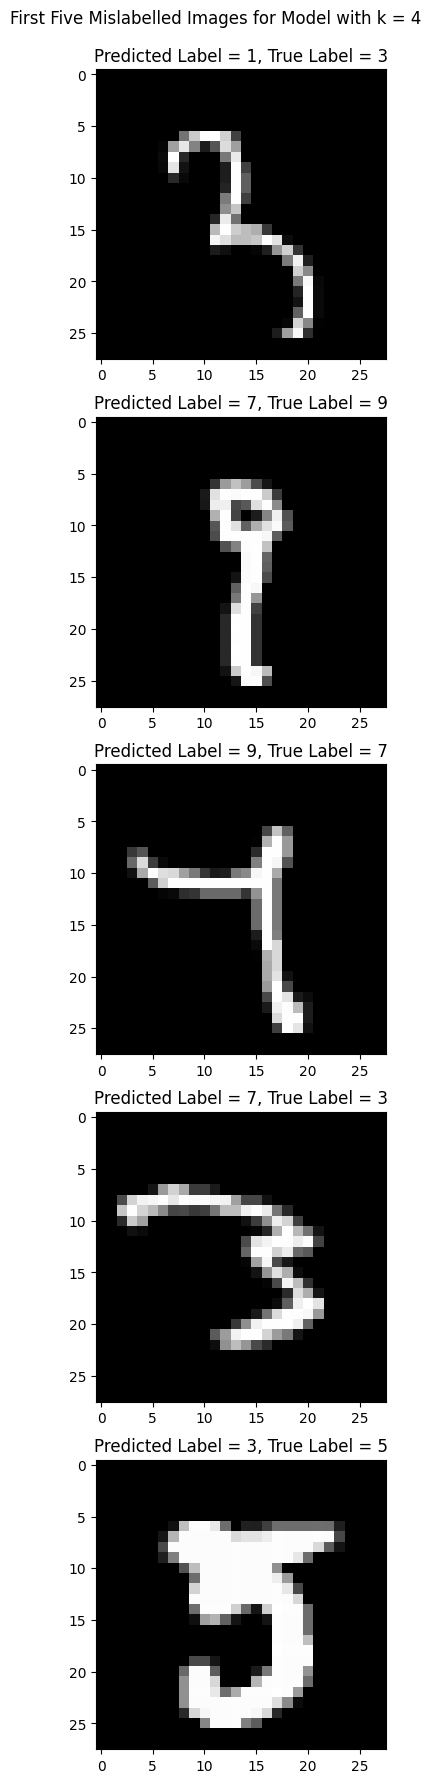

In [16]:
mislabled_indices = np.where(all_model_predictions[0] != y_test_subset_rel)[0]
plt.figure(figsize=(20, 20))
plt.suptitle('First Five Mislabelled Images for Model with k = 4')
plt.subplots_adjust(top=0.95) 
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.title(f'Predicted Label = {all_model_predictions[0][mislabled_indices[i]]}, True Label = {y_test_subset_rel[mislabled_indices[i]]}')
    plt.imshow(x_test_subset_rel[mislabled_indices[i]], cmap='gray')
plt.show()

**Based on the patterns in the pixel values for each category, which labels (numbers) do you think the model might struggle to identify or distinguish from one another? Explain why certain labels might be more challenging to separate, considering the similarity in pixel patterns or shapes.**

The model struggles to distinguish between labels that have similar structural features, such as 1 and 7 (as also evidenced above), 3 and 5, etc. These labels can be challenging to separate since they can look very similar when drawn or written with minor variations, even if drawn or written perfectly, leading to model misclassification and confusion.

## 3.4 Comprehension Questions

**Why is it important to have separate training and testing datasets? What potential issues arise if you use the same data for both training and evaluation?**

Separate training and testing datasets allow for model generalizability. If we train and evaluate on the same dataset, we will not be able to determine model performance on unseen data, which would impact real-world usage.

**If you achieve a high accuracy on the training set but a lower accuracy on the testing set, what might this indicate about your model’s performance and generalization?**

This indicates that the model is overfitting to the training dataset, making it less generalizable. When overfitting occurs, the model learns not only the underlying patterns but also the noise in the training data. As a result, when presented with an unseen dataset (i.e., test data) that lacks this noise, the model does not perform well.

# Citations

AI support was sought sparingly, but throughout the notebook using:

DeepSeek. (2025). DeepSeek-V3 (Jan 30 version) [Large language model]. 
    https://chat.deepseek.com

OpenAI. (2025). ChatGPT (Jan 30 version) [Large language model]. 
    https://chat.openai.com/chat